# Example 10.23
Given that  $\dfrac{dy}{dx}=x^{2}(1+y),\; y(1)=1,\; y(1.1)=1.233,\; y(1.2)=1.548,\; y(1.3)=1.979$, evaluate y(1.4) by adams-bashforth method

Adam Iter 0, Loss 2.870e+00
Adam Iter 1000, Loss 2.229e-04
Adam Iter 2000, Loss 2.359e-03
Adam Iter 3000, Loss 6.546e-06
Adam Iter 4000, Loss 3.944e-06
Adam Iter 5000, Loss 2.551e-06
Adam Iter 6000, Loss 1.782e-06
Adam Iter 7000, Loss 1.432e-06
Adam Iter 8000, Loss 1.218e-06
Adam Iter 9000, Loss 1.338e-06
x=1.0, Adams=1.000000, SciPy=1.000000, PINN=0.999998
x=1.1, Adams=1.233300, SciPy=1.233303, PINN=1.233270
x=1.2, Adams=1.549286, SciPy=1.549289, PINN=1.549284
x=1.3, Adams=1.980663, SciPy=1.980665, PINN=1.980660
x=1.4, Adams=2.577153, SciPy=2.576843, PINN=2.576838


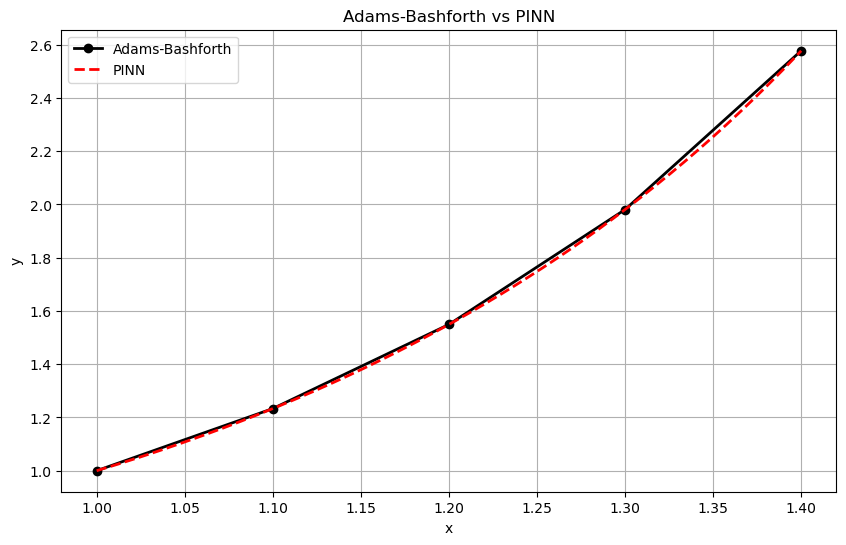

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# =============================== 
# 1. SciPy Solution
# ===============================
def f(x, y):
    return x**2*(1 + y)

scipy = solve_ivp(f, (1, 1.4), [1], method='RK45', t_eval=np.linspace(1, 1.4, 5), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
def rk4(f, x0, y0, h, n):
    xs = [x0]
    ys = [y0]
    x = x0
    y = y0

    for i in range(n):
        k1 = h * f(x, y)
        k2 = h * f(x + h/2, y + k1/2)
        k3 = h * f(x + h/2, y + k2/2)
        k4 = h * f(x + h, y + k3)
        y = y + (k1 + 2*k2 + 2*k3 + k4) / 6
        x = x + h
        xs.append(x)
        ys.append(y)
    return xs, ys

xs, ys = rk4(f, 1, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 4):
    yp = ys[i] + (h/24)*(55*f(xs[i], ys[i]) - 59*f(xs[i-1], ys[i-1]) + 37*f(xs[i-2], ys[i-2]) - 9*f(xs[i-3], ys[i-3]))
    x_next = xs[i] + h
    yc = ys[i] + (h/24)*(9*f(x_next, yp) + 19*f(xs[i], ys[i]) -5*f(xs[i-1], ys[i-1]) +f(xs[i-2], ys[i-2]))
    while True:
        yc_new = ys[i] + (h/24)*(9*f(x_next, yc) + 19*f(xs[i], ys[i]) -5*f(xs[i-1], ys[i-1]) +f(xs[i-2], ys[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs.append(x_next)
    ys.append(yc)
# ================================
# 3. PINN
# ================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

x_colloc = torch.linspace(1, 1.4, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([[1.0]], dtype=torch.float32, device=device)
y0 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - x_colloc**2 * (1 + y)
    loss_pde = torch.mean(f_pde**2)
    
    y0_pred = model(x0)
    loss_ic = torch.mean((y0_pred - y0)**2)
    
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

# Predictions
x_pinn = torch.linspace(1, 1.4, 5, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn = model(x_pinn).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs, ys, scipy.y[0], y_pinn):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_pinn_plot = torch.linspace(1, 1.4, 200, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_plot = model(x_pinn_plot).detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_pinn_plot, y_pinn_plot, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs PINN')
plt.legend()
plt.grid(True)
plt.show()

# Example 10.24
If $\frac{dy}{dx} = 2e^{x}y$, $y(0)=2$, find $y(0.4)$ using Adams predictor-corrector formula

Adam Iter 0, Loss 4.180e+00
Adam Iter 1000, Loss 2.167e-04
Adam Iter 2000, Loss 1.258e-04
Adam Iter 3000, Loss 3.139e-04
Adam Iter 4000, Loss 4.212e-05
Adam Iter 5000, Loss 1.744e-05
Adam Iter 6000, Loss 8.336e-06
Adam Iter 7000, Loss 4.682e-06
Adam Iter 8000, Loss 1.474e-04
Adam Iter 9000, Loss 3.371e-04
x=0.0, Adams=2.000000, SciPy=2.000000, PINN=2.000000
x=0.1, Adams=2.468192, SciPy=2.468198, PINN=2.468160
x=0.2, Adams=3.114115, SciPy=3.114139, PINN=3.114177
x=0.3, Adams=4.026306, SciPy=4.026370, PINN=4.026361
x=0.4, Adams=5.349641, SciPy=5.348396, PINN=5.348391


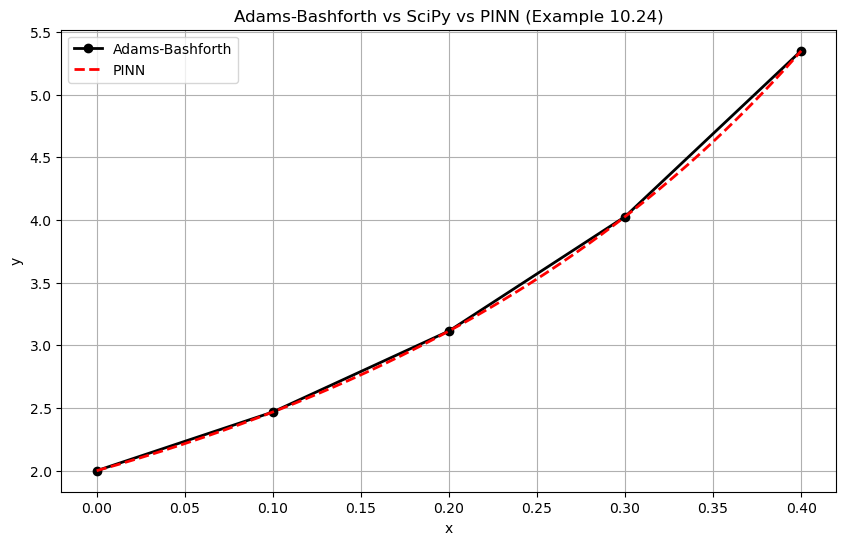

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
# ===============================
# 1. SciPy Solution
# ===============================
def f(x, y):
    return 2*np.exp(x)*y

scipy = integrate.solve_ivp(f, (0, 0.4), [2], method='RK45', t_eval=np.linspace(0, 0.4, 5), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
xs2, ys2 = rk4(f, 0, 2, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 4):
    yp = ys2[i] + (h/24)*(55*f(xs2[i], ys2[i]) - 59*f(xs2[i-1], ys2[i-1]) + 37*f(xs2[i-2], ys2[i-2]) - 9*f(xs2[i-3], ys2[i-3]))
    x_next = xs2[i] + h
    yc = ys2[i] + (h/24)*(9*f(x_next, yp) + 19*f(xs2[i], ys2[i]) - 5*f(xs2[i-1], ys2[i-1]) + f(xs2[i-2], ys2[i-2]))
    while True:
        yc_new = ys2[i] + (h/24)*(9*f(x_next, yc) + 19*f(xs2[i], ys2[i]) - 5*f(xs2[i-1], ys2[i-1]) + f(xs2[i-2], ys2[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs2.append(x_next)
    ys2.append(yc)
# ================================
# 3. PINN
# ================================
model2 = PINN().to(device)
x_colloc2 = torch.linspace(0, 0.4, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0_2 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0_2 = torch.tensor([[2.0]], dtype=torch.float32, device=device)

def pinn_loss2():
    y = model2(x_colloc2)
    dy = torch.autograd.grad(y, x_colloc2, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - 2*torch.exp(x_colloc2)*y
    loss_pde = torch.mean(f_pde**2)
    y0_pred = model2(x0_2)
    loss_ic = torch.mean((y0_pred - y0_2)**2)
    return loss_pde + loss_ic

optimizer_adam2 = optim.Adam(model2.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam2.zero_grad()
    loss = pinn_loss2()
    loss.backward()
    optimizer_adam2.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs2 = optim.LBFGS(model2.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure2():
    optimizer_lbfgs2.zero_grad()
    loss = pinn_loss2()
    loss.backward()
    return loss
optimizer_lbfgs2.step(closure2)

x_vals2 = torch.linspace(0, 0.4, 5, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn2 = model2(x_vals2).detach().numpy().flatten()

for xi, yi, zi, pi in zip(xs2, ys2, scipy.y[0], y_pinn2):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_plot2 = np.linspace(0, 0.4, 200).reshape(-1, 1)
x_plot2_torch = torch.tensor(x_plot2, dtype=torch.float32, device=device)
y_pinn2_plot = model2(x_plot2_torch).detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs2, ys2, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_plot2, y_pinn2_plot, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs SciPy vs PINN (Example 10.24)')
plt.legend()
plt.grid(True)
plt.show()

# Example 10.25
Solve $\frac{dy}{dx} = x - y^2$, $y(0)=1$, to find $y(0.4)$ using Adams method with RK4 startup ($h = 0.1$)

Adam Iter 0, Loss 1.403e+00
Adam Iter 1000, Loss 6.299e-05
Adam Iter 2000, Loss 3.040e-05
Adam Iter 3000, Loss 1.137e-05
Adam Iter 4000, Loss 6.200e-06
Adam Iter 5000, Loss 1.502e-06
Adam Iter 6000, Loss 5.448e-07
Adam Iter 7000, Loss 3.724e-07
Adam Iter 8000, Loss 2.749e-07
Adam Iter 9000, Loss 2.986e-07
x=0.0, Adams=1.000000, SciPy=1.000000, PINN=0.999995
x=0.1, Adams=0.913795, SciPy=0.913794, PINN=0.913766
x=0.2, Adams=0.851192, SciPy=0.851192, PINN=0.851184
x=0.3, Adams=0.807622, SciPy=0.807622, PINN=0.807625
x=0.4, Adams=0.779798, SciPy=0.779808, PINN=0.779802


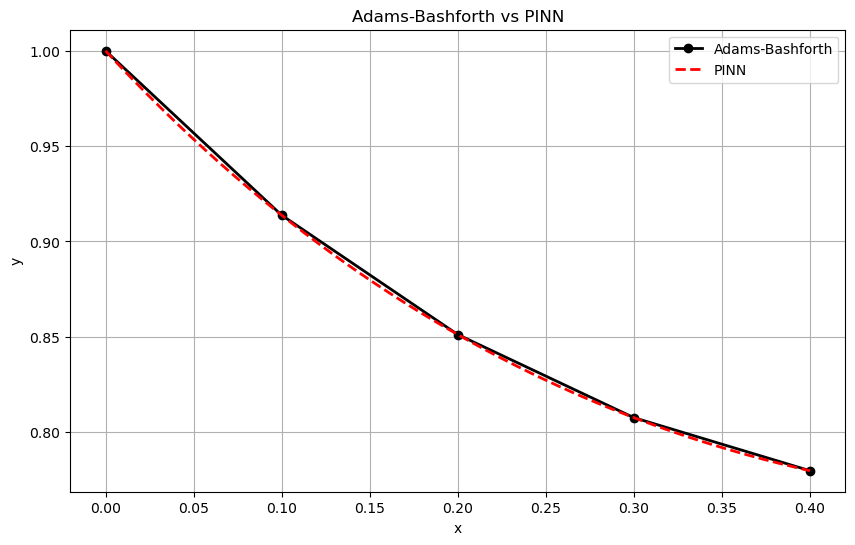

In [19]:
# ===============================
# 1. SciPy Solution
# ===============================
def f3(x, y):
    return x - y**2

scipy3 = solve_ivp(f3, (0, 0.4), [1], method='RK45', t_eval=np.linspace(0, 0.4, 5), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
xs3, ys3 = rk4(f3, 0, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 4):
    yp = ys3[i] + (h/24)*(55*f3(xs3[i], ys3[i]) - 59*f3(xs3[i-1], ys3[i-1]) + 37*f3(xs3[i-2], ys3[i-2]) - 9*f3(xs3[i-3], ys3[i-3]))
    x_next = xs3[i] + h
    yc = ys3[i] + (h/24)*(9*f3(x_next, yp) + 19*f3(xs3[i], ys3[i]) - 5*f3(xs3[i-1], ys3[i-1]) + f3(xs3[i-2], ys3[i-2]))
    while True:
        yc_new = ys3[i] + (h/24)*(9*f3(x_next, yc) + 19*f3(xs3[i], ys3[i]) - 5*f3(xs3[i-1], ys3[i-1]) + f3(xs3[i-2], ys3[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs3.append(x_next)
    ys3.append(yc)
# ================================
# 3. PINN
# ================================
model3 = PINN().to(device)
x_colloc3 = torch.linspace(0, 0.4, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0_3 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0_3 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss3():
    y = model3(x_colloc3)
    dy = torch.autograd.grad(y, x_colloc3, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - (x_colloc3 - y**2)
    loss_pde = torch.mean(f_pde**2)
    y0_pred = model3(x0_3)
    loss_ic = torch.mean((y0_pred - y0_3)**2)
    return loss_pde + loss_ic

optimizer_adam3 = optim.Adam(model3.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam3.zero_grad()
    loss = pinn_loss3()
    loss.backward()
    optimizer_adam3.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs3 = optim.LBFGS(model3.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure3():
    optimizer_lbfgs3.zero_grad()
    loss = pinn_loss3()
    loss.backward()
    return loss
optimizer_lbfgs3.step(closure3)

x_vals3 = torch.linspace(0, 0.4, 5, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn3 = model3(x_vals3).detach().cpu().numpy().flatten()

for xi, yi, zi, pi in zip(xs3, ys3, scipy3.y[0], y_pinn3):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_plot3 = np.linspace(0, 0.4, 200).reshape(-1, 1)
x_plot3_torch = torch.tensor(x_plot3, dtype=torch.float32, device=device)
y_pinn3_plot = model3(x_plot3_torch).detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs3, ys3, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_plot3, y_pinn3_plot, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs PINN')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 1
Solve $\frac{dy}{dx} = x - y^2$, $y(0)=0$, find values up to $y(1)$ using $h = 0.2$

Adam Iter 0, Loss 2.566e-01
Adam Iter 2000, Loss 3.519e-06
Adam Iter 4000, Loss 3.055e-07
Adam Iter 6000, Loss 3.341e-06
Adam Iter 8000, Loss 2.576e-06
x=0.0, Adams=0.000000, SciPy=0.000000, PINN=0.000002
x=0.2, Adams=0.019980, SciPy=0.019981, PINN=0.019956
x=0.4, Adams=0.079484, SciPy=0.079495, PINN=0.079458
x=0.6, Adams=0.176204, SciPy=0.176215, PINN=0.176175
x=0.8, Adams=0.304590, SciPy=0.304599, PINN=0.304572
x=1.0, Adams=0.455575, SciPy=0.455545, PINN=0.455529


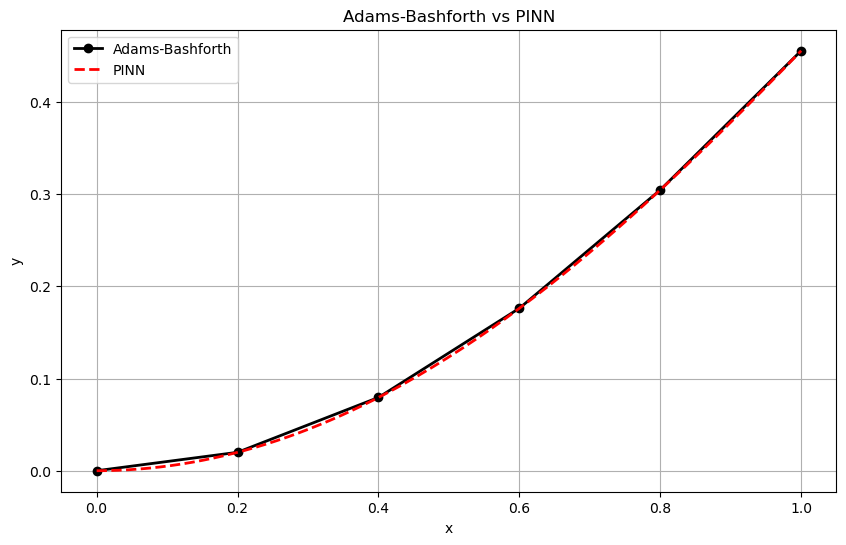

In [18]:
# ===============================
# 1. SciPy Solution
# ===============================
def f_ex1(x, y):
    return x - y**2

scipy_ex1 = solve_ivp(f_ex1, (0, 1), [0], method='RK45', t_eval=np.linspace(0, 1, 6), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
xs_ex1, ys_ex1 = rk4(f_ex1, 0, 0, 0.2, 3)

h = 0.2
tol = 1e-6
for i in range(3, 5):
    yp = ys_ex1[i] + (h/24)*(55*f_ex1(xs_ex1[i], ys_ex1[i]) - 59*f_ex1(xs_ex1[i-1], ys_ex1[i-1]) + 37*f_ex1(xs_ex1[i-2], ys_ex1[i-2]) - 9*f_ex1(xs_ex1[i-3], ys_ex1[i-3]))
    x_next = xs_ex1[i] + h
    yc = ys_ex1[i] + (h/24)*(9*f_ex1(x_next, yp) + 19*f_ex1(xs_ex1[i], ys_ex1[i]) - 5*f_ex1(xs_ex1[i-1], ys_ex1[i-1]) + f_ex1(xs_ex1[i-2], ys_ex1[i-2]))
    while True:
        yc_new = ys_ex1[i] + (h/24)*(9*f_ex1(x_next, yc) + 19*f_ex1(xs_ex1[i], ys_ex1[i]) - 5*f_ex1(xs_ex1[i-1], ys_ex1[i-1]) + f_ex1(xs_ex1[i-2], ys_ex1[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs_ex1.append(x_next)
    ys_ex1.append(yc)
# ================================
# 3. PINN
# ================================
model_ex1 = PINN().to(device)
x_colloc_ex1 = torch.linspace(0, 1, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0_ex1 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0_ex1 = torch.tensor([[0.0]], dtype=torch.float32, device=device)

def pinn_loss_ex1():
    y = model_ex1(x_colloc_ex1)
    dy = torch.autograd.grad(y, x_colloc_ex1, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - (x_colloc_ex1 - y**2)
    loss_pde = torch.mean(f_pde**2)
    y0_pred = model_ex1(x0_ex1)
    loss_ic = torch.mean((y0_pred - y0_ex1)**2)
    return loss_pde + loss_ic

optimizer_adam_ex1 = optim.Adam(model_ex1.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam_ex1.zero_grad()
    loss = pinn_loss_ex1()
    loss.backward()
    optimizer_adam_ex1.step()
    if it % 2000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs_ex1 = optim.LBFGS(model_ex1.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure_ex1():
    optimizer_lbfgs_ex1.zero_grad()
    loss = pinn_loss_ex1()
    loss.backward()
    return loss
optimizer_lbfgs_ex1.step(closure_ex1)

x_vals_ex1 = torch.linspace(0, 1, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_ex1 = model_ex1(x_vals_ex1).detach().cpu().numpy().flatten()

for xi, yi, zi, pi in zip(xs_ex1, ys_ex1, scipy_ex1.y[0], y_pinn_ex1):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_plot_ex1 = np.linspace(0, 1, 200).reshape(-1, 1)
x_plot_ex1_torch = torch.tensor(x_plot_ex1, dtype=torch.float32, device=device)
y_pinn_plot_ex1 = model_ex1(x_plot_ex1_torch).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs_ex1, ys_ex1, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_plot_ex1, y_pinn_plot_ex1, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs PINN')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 2
Solve $\frac{dy}{dx} = 0.5xy$, $y(0)=1$, find values up to $y(0.5)$ using $h = 0.1$

Adam Iter 0, Loss 8.032e-01
Adam Iter 2000, Loss 2.560e-06
Adam Iter 4000, Loss 1.324e-06
Adam Iter 6000, Loss 8.553e-07
Adam Iter 8000, Loss 3.776e-07
x=0.0, Adams=1.000000, SciPy=1.000000, PINN=0.999998
x=0.1, Adams=1.002503, SciPy=1.002503, PINN=1.002520
x=0.2, Adams=1.010050, SciPy=1.010051, PINN=1.010022
x=0.3, Adams=1.022755, SciPy=1.022755, PINN=1.022727
x=0.4, Adams=1.040811, SciPy=1.040810, PINN=1.040819
x=0.5, Adams=1.064495, SciPy=1.064494, PINN=1.064492


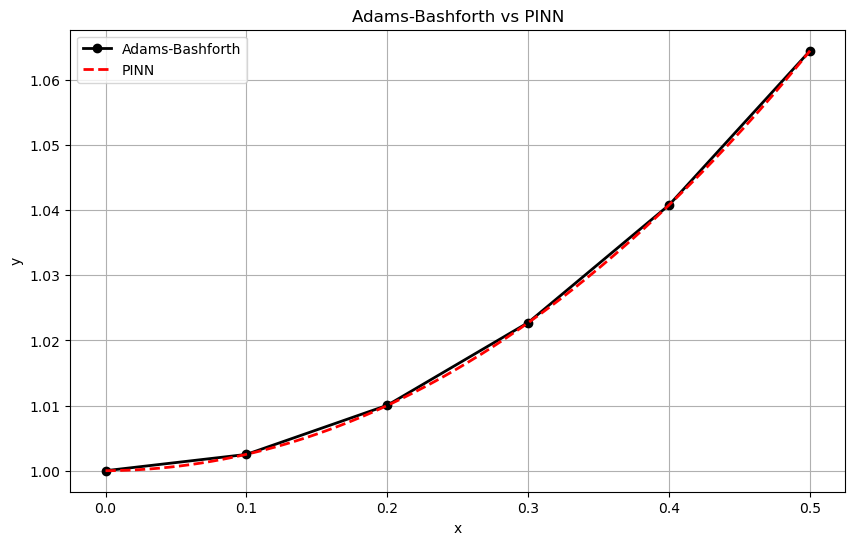

In [17]:
# ===============================
# 1. SciPy Solution
# ===============================
def f_ex2(x, y):
    return 0.5*x*y

scipy_ex2 = solve_ivp(f_ex2, (0, 0.5), [1], method='RK45', t_eval=np.linspace(0, 0.5, 6), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
xs_ex2, ys_ex2 = rk4(f_ex2, 0, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 5):
    yp = ys_ex2[i] + (h/24)*(55*f_ex2(xs_ex2[i], ys_ex2[i]) - 59*f_ex2(xs_ex2[i-1], ys_ex2[i-1]) + 37*f_ex2(xs_ex2[i-2], ys_ex2[i-2]) - 9*f_ex2(xs_ex2[i-3], ys_ex2[i-3]))
    x_next = xs_ex2[i] + h
    yc = ys_ex2[i] + (h/24)*(9*f_ex2(x_next, yp) + 19*f_ex2(xs_ex2[i], ys_ex2[i]) - 5*f_ex2(xs_ex2[i-1], ys_ex2[i-1]) + f_ex2(xs_ex2[i-2], ys_ex2[i-2]))
    while True:
        yc_new = ys_ex2[i] + (h/24)*(9*f_ex2(x_next, yc) + 19*f_ex2(xs_ex2[i], ys_ex2[i]) - 5*f_ex2(xs_ex2[i-1], ys_ex2[i-1]) + f_ex2(xs_ex2[i-2], ys_ex2[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs_ex2.append(x_next)
    ys_ex2.append(yc)

# ================================
# 3. PINN
# ================================
model_ex2 = PINN().to(device)
x_colloc_ex2 = torch.linspace(0, 0.5, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0_ex2 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0_ex2 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss_ex2():
    y = model_ex2(x_colloc_ex2)
    dy = torch.autograd.grad(y, x_colloc_ex2, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - 0.5*x_colloc_ex2*y
    loss_pde = torch.mean(f_pde**2)
    y0_pred = model_ex2(x0_ex2)
    loss_ic = torch.mean((y0_pred - y0_ex2)**2)
    return loss_pde + loss_ic

optimizer_adam_ex2 = optim.Adam(model_ex2.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam_ex2.zero_grad()
    loss = pinn_loss_ex2()
    loss.backward()
    optimizer_adam_ex2.step()
    if it % 2000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs_ex2 = optim.LBFGS(model_ex2.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure_ex2():
    optimizer_lbfgs_ex2.zero_grad()
    loss = pinn_loss_ex2()
    loss.backward()
    return loss
optimizer_lbfgs_ex2.step(closure_ex2)

x_vals_ex2 = torch.linspace(0, 0.5, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_ex2 = model_ex2(x_vals_ex2).detach().cpu().numpy().flatten()

for xi, yi, zi, pi in zip(xs_ex2, ys_ex2, scipy_ex2.y[0], y_pinn_ex2):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_plot_ex2 = np.linspace(0, 0.5, 200).reshape(-1, 1)
x_plot_ex2_torch = torch.tensor(x_plot_ex2, dtype=torch.float32, device=device)
y_pinn_plot_ex2 = model_ex2(x_plot_ex2_torch).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs_ex2, ys_ex2, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_plot_ex2, y_pinn_plot_ex2, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs PINN')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 3
Solve $\frac{dy}{dx} = x^2 - y$, $y(0)=1$, find values up to $y(0.5)$ using $h = 0.1$

Adam Iter 0, Loss 1.153e+00
Adam Iter 2000, Loss 3.605e-05
Adam Iter 4000, Loss 1.901e-05
Adam Iter 6000, Loss 1.584e-04
Adam Iter 8000, Loss 3.381e-07
x=0.0, Adams=1.000000, SciPy=1.000000, PINN=0.999998
x=0.1, Adams=0.905163, SciPy=0.905162, PINN=0.905170
x=0.2, Adams=0.821269, SciPy=0.821268, PINN=0.821260
x=0.3, Adams=0.749182, SciPy=0.749182, PINN=0.749150
x=0.4, Adams=0.689681, SciPy=0.689680, PINN=0.689691
x=0.5, Adams=0.643470, SciPy=0.643470, PINN=0.643470


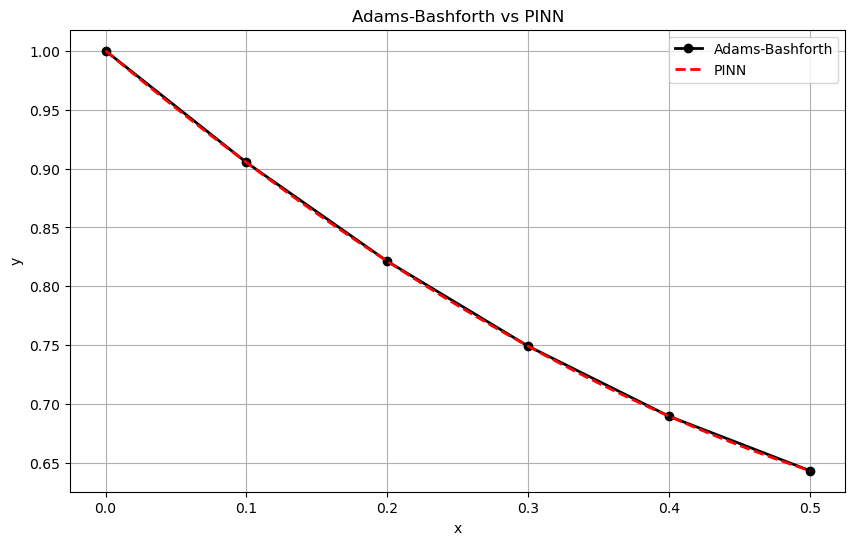

In [16]:
# ===============================
# 1. SciPy Solution
# ===============================
def f_ex3(x, y):
    return x**2 - y

scipy_ex3 = solve_ivp(f_ex3, (0, 0.5), [1], method='RK45', t_eval=np.linspace(0, 0.5, 6), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
xs_ex3, ys_ex3 = rk4(f_ex3, 0, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 5):
    yp = ys_ex3[i] + (h/24)*(55*f_ex3(xs_ex3[i], ys_ex3[i]) - 59*f_ex3(xs_ex3[i-1], ys_ex3[i-1]) + 37*f_ex3(xs_ex3[i-2], ys_ex3[i-2]) - 9*f_ex3(xs_ex3[i-3], ys_ex3[i-3]))
    x_next = xs_ex3[i] + h
    yc = ys_ex3[i] + (h/24)*(9*f_ex3(x_next, yp) + 19*f_ex3(xs_ex3[i], ys_ex3[i]) - 5*f_ex3(xs_ex3[i-1], ys_ex3[i-1]) + f_ex3(xs_ex3[i-2], ys_ex3[i-2]))
    while True:
        yc_new = ys_ex3[i] + (h/24)*(9*f_ex3(x_next, yc) + 19*f_ex3(xs_ex3[i], ys_ex3[i]) - 5*f_ex3(xs_ex3[i-1], ys_ex3[i-1]) + f_ex3(xs_ex3[i-2], ys_ex3[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs_ex3.append(x_next)
    ys_ex3.append(yc)

# ================================
# 3. PINN
# ================================
model_ex3 = PINN().to(device)
x_colloc_ex3 = torch.linspace(0, 0.5, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0_ex3 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0_ex3 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss_ex3():
    y = model_ex3(x_colloc_ex3)
    dy = torch.autograd.grad(y, x_colloc_ex3, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - (x_colloc_ex3**2 - y)
    loss_pde = torch.mean(f_pde**2)
    y0_pred = model_ex3(x0_ex3)
    loss_ic = torch.mean((y0_pred - y0_ex3)**2)
    return loss_pde + loss_ic

optimizer_adam_ex3 = optim.Adam(model_ex3.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam_ex3.zero_grad()
    loss = pinn_loss_ex3()
    loss.backward()
    optimizer_adam_ex3.step()
    if it % 2000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs_ex3 = optim.LBFGS(model_ex3.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure_ex3():
    optimizer_lbfgs_ex3.zero_grad()
    loss = pinn_loss_ex3()
    loss.backward()
    return loss
optimizer_lbfgs_ex3.step(closure_ex3)

x_vals_ex3 = torch.linspace(0, 0.5, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_ex3 = model_ex3(x_vals_ex3).detach().cpu().numpy().flatten()

for xi, yi, zi, pi in zip(xs_ex3, ys_ex3, scipy_ex3.y[0], y_pinn_ex3):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_plot_ex3 = np.linspace(0, 0.5, 200).reshape(-1, 1)
x_plot_ex3_torch = torch.tensor(x_plot_ex3, dtype=torch.float32, device=device)
y_pinn_plot_ex3 = model_ex3(x_plot_ex3_torch).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs_ex3, ys_ex3, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_plot_ex3, y_pinn_plot_ex3, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs PINN')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 4
Solve $\frac{dy}{dx} = \frac{2-y^2}{5x}$, $y(4)=1$, find values up to $y(4.5)$ using $h = 0.1$

Adam Iter 0, Loss 8.031e-01
Adam Iter 2000, Loss 1.424e-06
Adam Iter 4000, Loss 3.160e-07
Adam Iter 6000, Loss 3.798e-09
Adam Iter 8000, Loss 1.086e-08
x=4.0, Adams=1.000000, SciPy=1.000000, PINN=1.000000
x=4.1, Adams=1.004914, SciPy=1.004914, PINN=1.004928
x=4.2, Adams=1.009663, SciPy=1.009663, PINN=1.009683
x=4.3, Adams=1.014256, SciPy=1.014256, PINN=1.014275
x=4.4, Adams=1.018701, SciPy=1.018701, PINN=1.018713
x=4.5, Adams=1.023006, SciPy=1.023006, PINN=1.023004


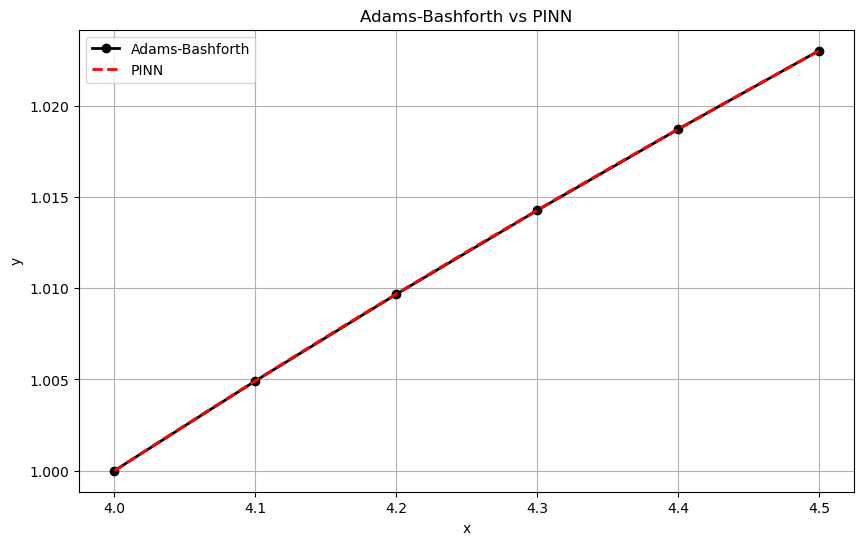

In [15]:
# ===============================
# 1. SciPy Solution
# ===============================
def f_ex4(x, y):
    return (2 - y**2)/(5*x)

scipy_ex4 = solve_ivp(f_ex4, (4, 4.5), [1], method='RK45', t_eval=np.linspace(4, 4.5, 6), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
xs_ex4, ys_ex4 = rk4(f_ex4, 4, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 5):
    yp = ys_ex4[i] + (h/24)*(55*f_ex4(xs_ex4[i], ys_ex4[i]) - 59*f_ex4(xs_ex4[i-1], ys_ex4[i-1]) + 37*f_ex4(xs_ex4[i-2], ys_ex4[i-2]) - 9*f_ex4(xs_ex4[i-3], ys_ex4[i-3]))
    x_next = xs_ex4[i] + h
    yc = ys_ex4[i] + (h/24)*(9*f_ex4(x_next, yp) + 19*f_ex4(xs_ex4[i], ys_ex4[i]) - 5*f_ex4(xs_ex4[i-1], ys_ex4[i-1]) + f_ex4(xs_ex4[i-2], ys_ex4[i-2]))
    while True:
        yc_new = ys_ex4[i] + (h/24)*(9*f_ex4(x_next, yc) + 19*f_ex4(xs_ex4[i], ys_ex4[i]) - 5*f_ex4(xs_ex4[i-1], ys_ex4[i-1]) + f_ex4(xs_ex4[i-2], ys_ex4[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs_ex4.append(x_next)
    ys_ex4.append(yc)

# ================================
# 3. PINN
# ================================
model_ex4 = PINN().to(device)
x_colloc_ex4 = torch.linspace(4, 4.5, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0_ex4 = torch.tensor([[4.0]], dtype=torch.float32, device=device)
y0_ex4 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss_ex4():
    y = model_ex4(x_colloc_ex4)
    dy = torch.autograd.grad(y, x_colloc_ex4, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - (2 - y**2)/(5*x_colloc_ex4)
    loss_pde = torch.mean(f_pde**2)
    y0_pred = model_ex4(x0_ex4)
    loss_ic = torch.mean((y0_pred - y0_ex4)**2)
    return loss_pde + loss_ic

optimizer_adam_ex4 = optim.Adam(model_ex4.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam_ex4.zero_grad()
    loss = pinn_loss_ex4()
    loss.backward()
    optimizer_adam_ex4.step()
    if it % 2000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs_ex4 = optim.LBFGS(model_ex4.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure_ex4():
    optimizer_lbfgs_ex4.zero_grad()
    loss = pinn_loss_ex4()
    loss.backward()
    return loss
optimizer_lbfgs_ex4.step(closure_ex4)

x_vals_ex4 = torch.linspace(4, 4.5, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_ex4 = model_ex4(x_vals_ex4).detach().cpu().numpy().flatten()

for xi, yi, zi, pi in zip(xs_ex4, ys_ex4, scipy_ex4.y[0], y_pinn_ex4):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_plot_ex4 = np.linspace(4, 4.5, 200).reshape(-1, 1)
x_plot_ex4_torch = torch.tensor(x_plot_ex4, dtype=torch.float32, device=device)
y_pinn_plot_ex4 = model_ex4(x_plot_ex4_torch).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs_ex4, ys_ex4, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_plot_ex4, y_pinn_plot_ex4, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs PINN')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 5
Solve $\frac{dy}{dx} = x^2(1+y)$, $y(1)=1$, find values up to $y(1.5)$ using $h = 0.1$

Adam Iter 0, Loss 3.788e+00
Adam Iter 2000, Loss 8.161e-05
Adam Iter 4000, Loss 2.076e-05
Adam Iter 6000, Loss 1.349e-04
Adam Iter 8000, Loss 1.150e-06
x=1.0, Adams=1.000000, SciPy=1.000000, PINN=0.999992
x=1.1, Adams=1.233300, SciPy=1.233303, PINN=1.233261
x=1.2, Adams=1.549286, SciPy=1.549289, PINN=1.549295
x=1.3, Adams=1.980663, SciPy=1.980665, PINN=1.980626
x=1.4, Adams=2.577153, SciPy=2.576842, PINN=2.576853
x=1.5, Adams=3.415081, SciPy=3.414144, PINN=3.414124


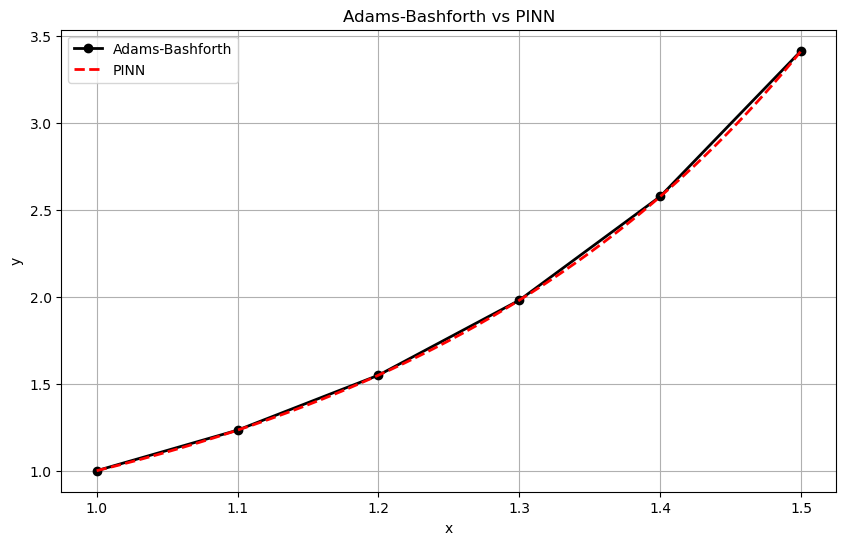

In [14]:
# ===============================
# 1. SciPy Solution
# ===============================
def f_ex5(x, y):
    return x**2*(1 + y)

scipy_ex5 = solve_ivp(f_ex5, (1, 1.5), [1], method='RK45', t_eval=np.linspace(1, 1.5, 6), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
xs_ex5, ys_ex5 = rk4(f_ex5, 1, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 5):
    yp = ys_ex5[i] + (h/24)*(55*f_ex5(xs_ex5[i], ys_ex5[i]) - 59*f_ex5(xs_ex5[i-1], ys_ex5[i-1]) + 37*f_ex5(xs_ex5[i-2], ys_ex5[i-2]) - 9*f_ex5(xs_ex5[i-3], ys_ex5[i-3]))
    x_next = xs_ex5[i] + h
    yc = ys_ex5[i] + (h/24)*(9*f_ex5(x_next, yp) + 19*f_ex5(xs_ex5[i], ys_ex5[i]) - 5*f_ex5(xs_ex5[i-1], ys_ex5[i-1]) + f_ex5(xs_ex5[i-2], ys_ex5[i-2]))
    while True:
        yc_new = ys_ex5[i] + (h/24)*(9*f_ex5(x_next, yc) + 19*f_ex5(xs_ex5[i], ys_ex5[i]) - 5*f_ex5(xs_ex5[i-1], ys_ex5[i-1]) + f_ex5(xs_ex5[i-2], ys_ex5[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs_ex5.append(x_next)
    ys_ex5.append(yc)

# ================================
# 3. PINN
# ================================
model_ex5 = PINN().to(device)
x_colloc_ex5 = torch.linspace(1, 1.5, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0_ex5 = torch.tensor([[1.0]], dtype=torch.float32, device=device)
y0_ex5 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss_ex5():
    y = model_ex5(x_colloc_ex5)
    dy = torch.autograd.grad(y, x_colloc_ex5, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - x_colloc_ex5**2*(1 + y)
    loss_pde = torch.mean(f_pde**2)
    y0_pred = model_ex5(x0_ex5)
    loss_ic = torch.mean((y0_pred - y0_ex5)**2)
    return loss_pde + loss_ic

optimizer_adam_ex5 = optim.Adam(model_ex5.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam_ex5.zero_grad()
    loss = pinn_loss_ex5()
    loss.backward()
    optimizer_adam_ex5.step()
    if it % 2000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs_ex5 = optim.LBFGS(model_ex5.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure_ex5():
    optimizer_lbfgs_ex5.zero_grad()
    loss = pinn_loss_ex5()
    loss.backward()
    return loss
optimizer_lbfgs_ex5.step(closure_ex5)

x_vals_ex5 = torch.linspace(1, 1.5, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_ex5 = model_ex5(x_vals_ex5).detach().cpu().numpy().flatten()

for xi, yi, zi, pi in zip(xs_ex5, ys_ex5, scipy_ex5.y[0], y_pinn_ex5):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_plot_ex5 = np.linspace(1, 1.5, 200).reshape(-1, 1)
x_plot_ex5_torch = torch.tensor(x_plot_ex5, dtype=torch.float32, device=device)
y_pinn_plot_ex5 = model_ex5(x_plot_ex5_torch).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs_ex5, ys_ex5, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_plot_ex5, y_pinn_plot_ex5, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs PINN')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 6
Solve $\frac{dy}{dx} = \frac{1}{x^2} - \frac{y}{x}$, $y(1)=1$, find values up to $y(1.5)$ using $h = 0.1$

Adam Iter 0, Loss 9.720e-01
Adam Iter 2000, Loss 5.009e-05
Adam Iter 4000, Loss 2.003e-06
Adam Iter 6000, Loss 3.898e-07
Adam Iter 8000, Loss 2.732e-07
x=1.0, Adams=1.000000, SciPy=1.000000, PINN=1.000001
x=1.1, Adams=0.995737, SciPy=0.995736, PINN=0.995754
x=1.2, Adams=0.985268, SciPy=0.985273, PINN=0.985283
x=1.3, Adams=0.971050, SciPy=0.971046, PINN=0.971028
x=1.4, Adams=0.954631, SciPy=0.954623, PINN=0.954628
x=1.5, Adams=0.936989, SciPy=0.936977, PINN=0.936980


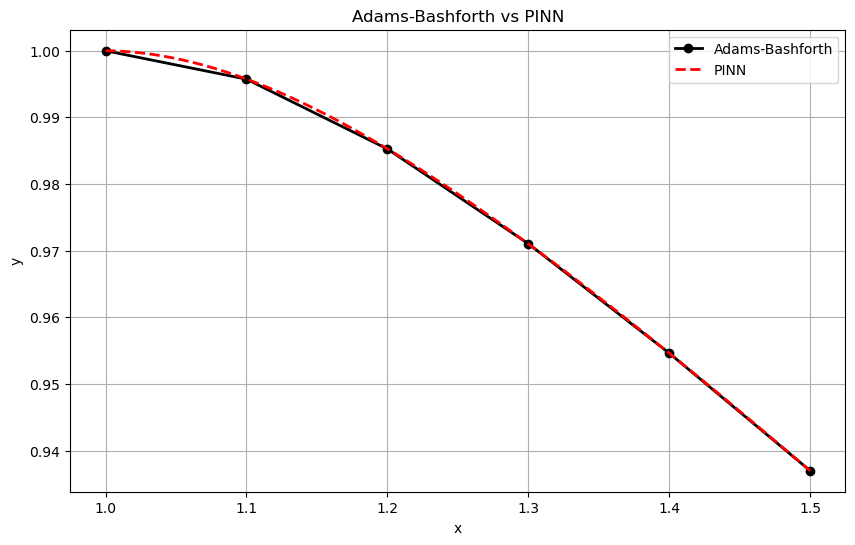

In [13]:
# ===============================
# 1. SciPy Solution
# ===============================
def f_ex6(x, y):
    return 1/x**2 - y/x

scipy_ex6 = solve_ivp(f_ex6, (1, 1.5), [1], method='RK45', t_eval=np.linspace(1, 1.5, 6), rtol=1e-6, atol=1e-6)

# ===============================
# 2. Adams-Bashforth Method
# ===============================
xs_ex6, ys_ex6 = rk4(f_ex6, 1, 1, 0.1, 3)

h = 0.1
tol = 1e-6
for i in range(3, 5):
    yp = ys_ex6[i] + (h/24)*(55*f_ex6(xs_ex6[i], ys_ex6[i]) - 59*f_ex6(xs_ex6[i-1], ys_ex6[i-1]) + 37*f_ex6(xs_ex6[i-2], ys_ex6[i-2]) - 9*f_ex6(xs_ex6[i-3], ys_ex6[i-3]))
    x_next = xs_ex6[i] + h
    yc = ys_ex6[i] + (h/24)*(9*f_ex6(x_next, yp) + 19*f_ex6(xs_ex6[i], ys_ex6[i]) - 5*f_ex6(xs_ex6[i-1], ys_ex6[i-1]) + f_ex6(xs_ex6[i-2], ys_ex6[i-2]))
    while True:
        yc_new = ys_ex6[i] + (h/24)*(9*f_ex6(x_next, yc) + 19*f_ex6(xs_ex6[i], ys_ex6[i]) - 5*f_ex6(xs_ex6[i-1], ys_ex6[i-1]) + f_ex6(xs_ex6[i-2], ys_ex6[i-2]))
        if abs(yc_new - yc) < tol:
            break
        yc = yc_new
    xs_ex6.append(x_next)
    ys_ex6.append(yc)

# ================================
# 3. PINN
# ================================
model_ex6 = PINN().to(device)
x_colloc_ex6 = torch.linspace(1, 1.5, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)
x0_ex6 = torch.tensor([[1.0]], dtype=torch.float32, device=device)
y0_ex6 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss_ex6():
    y = model_ex6(x_colloc_ex6)
    dy = torch.autograd.grad(y, x_colloc_ex6, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f_pde = dy - (1/x_colloc_ex6**2 - y/x_colloc_ex6)
    loss_pde = torch.mean(f_pde**2)
    y0_pred = model_ex6(x0_ex6)
    loss_ic = torch.mean((y0_pred - y0_ex6)**2)
    return loss_pde + loss_ic

optimizer_adam_ex6 = optim.Adam(model_ex6.parameters(), lr=5e-4)
for it in range(10000):
    optimizer_adam_ex6.zero_grad()
    loss = pinn_loss_ex6()
    loss.backward()
    optimizer_adam_ex6.step()
    if it % 2000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs_ex6 = optim.LBFGS(model_ex6.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')
def closure_ex6():
    optimizer_lbfgs_ex6.zero_grad()
    loss = pinn_loss_ex6()
    loss.backward()
    return loss
optimizer_lbfgs_ex6.step(closure_ex6)

x_vals_ex6 = torch.linspace(1, 1.5, 6, dtype=torch.float32, device=device).reshape(-1, 1)
y_pinn_ex6 = model_ex6(x_vals_ex6).detach().cpu().numpy().flatten()

for xi, yi, zi, pi in zip(xs_ex6, ys_ex6, scipy_ex6.y[0], y_pinn_ex6):
    print(f'x={xi:.1f}, Adams={yi:.6f}, SciPy={zi:.6f}, PINN={pi:.6f}')
# ================================
# 4. Plot
# ================================
x_plot_ex6 = np.linspace(1, 1.5, 200).reshape(-1, 1)
x_plot_ex6_torch = torch.tensor(x_plot_ex6, dtype=torch.float32, device=device)
y_pinn_plot_ex6 = model_ex6(x_plot_ex6_torch).detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(xs_ex6, ys_ex6, 'ko-', label='Adams-Bashforth', linewidth=2, markersize=6)
plt.plot(x_plot_ex6, y_pinn_plot_ex6, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adams-Bashforth vs PINN')
plt.legend()
plt.grid(True)
plt.show()